In [ ]:
import os
import csv
from pymongo import MongoClient
from PIL import Image
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel
from IPython.display import Image as JImage, display

### Connect to MongoDB

In [ ]:
client = MongoClient("mongodb://localhost:27017/")
db = client.face_db
collection = db.celebrities  

### Load CLIP encoder

In [ ]:
# CLIP is a powerful, general-purpose image understanding model that converts images into vectors so you can compare them mathematically.
# Those numbers are called embeddings.
model_id = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

### Embedding function

In [ ]:
# compute_embedding takes an image, passes it through CLIP, and returns the embedding (a list of numbers) that represents the image.
def compute_embedding(img_path):
    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        emb = model.get_image_features(**inputs)
    return emb.squeeze().numpy().tolist()

### Path to dataset

In [ ]:
# mine is in same folder as the notebook
dataset_folder = "Celebrity Faces Dataset"

### Create metadata CSV

In [ ]:
# We create csv file for the dataset to have a clean overview of out celebrity and the path of their image and their filename. 
#This helps us in debugging, training other models, opening the dataset in Excel or other tools and reusing the dataset without touching the MongoDb
csv_filename = "celebrity_dataset_metadata.csv"

with open(csv_filename, mode="w", newline="", encoding="utf-8") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["filename", "celebrity", "image_path"])  # header

    # Loop through celebrity folders
    for celebrity_name in os.listdir(dataset_folder):
        celeb_folder = os.path.join(dataset_folder, celebrity_name)

        if not os.path.isdir(celeb_folder):
            continue  # skip non-folders

        print(f"Processing celebrity: {celebrity_name}")

        # Loop through images inside the folder
        for filename in os.listdir(celeb_folder):
            if not filename.lower().endswith((".png", ".jpg", ".jpeg")):
                continue

            image_path = os.path.join(celeb_folder, filename)

            # Write metadata to CSV
            writer.writerow([filename, celebrity_name, image_path])

            # Compute embedding
            embedding = compute_embedding(image_path)

            # Insert into MongoDB
            collection.update_one(
                {
                    "filename": filename,
                    "celebrity": celebrity_name
                },
                {
                    "$set": {
                        "filename": filename,
                        "celebrity": celebrity_name,
                        "image_path": image_path,
                        "embedding": embedding
                    }
                },
                upsert=True
            )

        print(f"Finished: {celebrity_name}")

# For debugging we printed the processes to see the progress
print("All celebrities processed. Metadata CSV created.")

# Now for each image, we: know who the celebrity is/ know where the file is on disk/ and have its CLIP embedding saved

C:\Users\ASUS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Processing celebrity: Angelina Jolie
Finished: Angelina Jolie
Processing celebrity: Brad Pitt
Finished: Brad Pitt
Processing celebrity: Denzel Washington
Finished: Denzel Washington
Processing celebrity: Hugh Jackman
Finished: Hugh Jackman
Processing celebrity: Jennifer Lawrence
Finished: Jennifer Lawrence
Processing celebrity: Johnny Depp
Finished: Johnny Depp
Processing celebrity: Kate Winslet
Finished: Kate Winslet
Processing celebrity: Leonardo DiCaprio
Finished: Leonardo DiCaprio
Processing celebrity: Megan Fox
Finished: Megan Fox
Processing celebrity: Natalie Portman
Finished: Natalie Portman
Processing celebrity: Nicole Kidman
Finished: Nicole Kidman
Processing celebrity: Robert Downey Jr
Finished: Robert Downey Jr
Processing celebrity: Sandra Bullock
Finished: Sandra Bullock
Processing celebrity: Scarlett Johansson
Finished: Scarlett Johansson
Processing celebrity: Tom Cruise
Finished: Tom Cruise
Processing celebrity: Tom Hanks
Finished: Tom Hanks
Processing celebrity: Will Smi

# Find the most similar celebrity to the input image

### Connect to MongoDB

In [ ]:
client = MongoClient("mongodb://localhost:27017/")
db = client.face_db
collection = db.celebrities

### Load CLIP encoder

In [ ]:
model_id = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)

### Embedding function

In [ ]:
def compute_embedding(img_path):
    # Load the image and convert it to RGB format
    image = Image.open(img_path).convert("RGB")
    # Preprocess the image so CLIP can understand it
    inputs = processor(images=image, return_tensors="pt")    
    # Pass the image through the CLIP model to get its embedding
    # torch.no_grad() makes sure we don't track gradients (faster, no training)
    with torch.no_grad():
        emb = model.get_image_features(**inputs)
    # Convert the embedding tensor to a NumPy array
    return emb.squeeze().numpy()

### Cosine similarity

In [ ]:
# Cosine similarity: measures how close two embedding vectors are
def cosine_similarity(a, b):
    # Convert both inputs to NumPy arrays
    a = np.array(a)
    b = np.array(b)    
    # Compute cosine similarity:
    # dot product divided by the product of their magnitudes
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

### Load query image

In [27]:
# Choose the image that we want to test against the celebrity database
query_image = "generatedImage4.png" 
# Convert the input photo into an embedding for similarity comparison
query_emb = compute_embedding(query_image)

### Fetch all celebrity embeddings

In [28]:
# Fetch all celebrity embeddings
docs = list(collection.find({}))

### Compute similarity

In [29]:
results = []

for doc in docs: 
    # Calculate cosine similarity between the query embedding and this celebrity embedding
    score = cosine_similarity(query_emb, doc["embedding"])
    # Save all useful info so we can sort and show results later
    results.append({
        "celebrity": doc["celebrity"],
        "filename": doc["filename"],
        "image_path": doc["image_path"],
        "score": score
    })

# Sort descending by similarity
results = sorted(results, key=lambda x: x["score"], reverse=True)

best = results[0]

### Final result

Most similar celebrity: Kate Winslet
Similarity score: 0.7561457972705663
Matched image: 081_e9a7882a.jpg


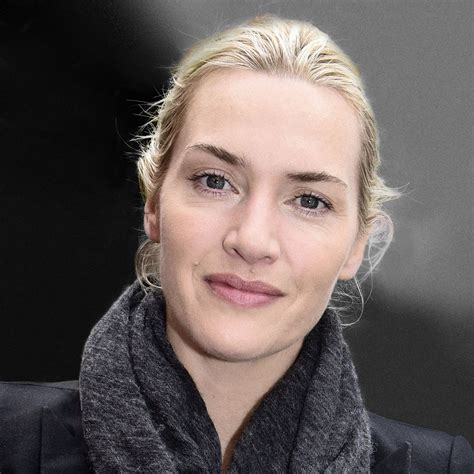

In [30]:
print("Most similar celebrity:", best["celebrity"])
print("Similarity score:", best["score"])
print("Matched image:", best["filename"])

display(JImage(filename=best["image_path"]))

In [31]:
# Print the top 5 most similar celebrities
print("\nTop 5 Matches:")
for r in results[:5]:
    print(r["celebrity"], "-", r["score"])


Top 5 Matches:
Kate Winslet - 0.7561457972705663
Scarlett Johansson - 0.701942648004575
Scarlett Johansson - 0.701942648004575
Scarlett Johansson - 0.6532721193774079
Natalie Portman - 0.6453783363951748
